## Import Data and Libraries

In [107]:
import math, re, os, warnings
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image_dataset_from_directory

import time

import warnings
warnings.filterwarnings('ignore')

In [108]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


### Import data

In [109]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [110]:
# Constants
BASE_DIR = r"dataset"
TRAIN_FILE = "train-00000-of-00001-c08a401c53fe5312.parquet"
TEST_FILE = "test-00000-of-00001-44110b9df98c5585.parquet"
LABELS = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}
# Read data in
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("notebooks"))
DATASET_DIR = os.path.join(NOTEBOOK_DIR, "../dataset")
# Fix the file path by joining the BASE_DIR and TRAIN_FILE correctly
train_file_path = os.path.join(DATASET_DIR, TRAIN_FILE).replace("\\", "/")
test_file_path = os.path.join(DATASET_DIR, TEST_FILE).replace("\\", "/")

train_data = pd.read_parquet(train_file_path).head(50)
test_data = pd.read_parquet(test_file_path).head(50)


Turning byte format into img

In [111]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        return img

In [112]:
train_data['image'] = train_data['image'].apply(dict_to_image)
test_data['image'] = test_data['image'].apply(dict_to_image)

In [113]:
train_data.head()


,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


In [114]:
train_data.head()


,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


**Split training data to get validation set**

In [115]:
X = train_data['image']
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.75, random_state=10)

In [116]:
X_test = test_data['image']
y_test = test_data['label']

Rejoin data into one dataframe

In [117]:
# Training data

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_df = pd.concat([X_train_df, y_train_df], axis=1)

# Validation data

X_val_df = pd.DataFrame(X_val)
y_val_df = pd.DataFrame(y_val)
val_df = pd.concat([X_val_df, y_val_df], axis=1)

In [118]:
# Test data
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

****

# **Exploratory Data Analysis**

In [119]:
train_df.head()

,image,label
32,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
10,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
21,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
35,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
27,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


**We can explore some images**

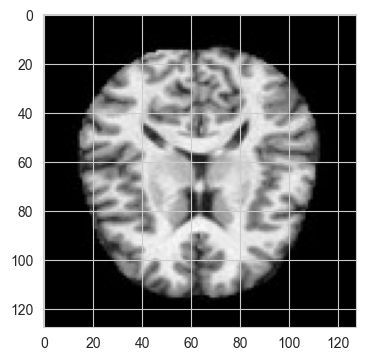

In [120]:
# Training images
mri_images = train_df['image']

fig = plt.figure(figsize=(10, 7)) 

for i in range(0, len(mri_images), 1000):
    n = int((i / 1000) + 1)
    
    fig.add_subplot(2,2,n)
    plt.imshow(mri_images.iloc[i])

plt.show()

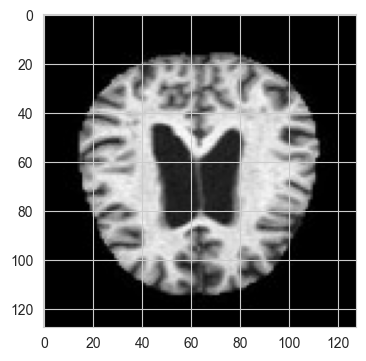

In [121]:
# Test images
mri_images_test = test_df['image']

fig = plt.figure(figsize=(10, 7)) 

for i in range(0, len(mri_images_test), 1000):
    n = int((i / 1000) + 1)
    
    fig.add_subplot(2,2,n)
    plt.imshow(mri_images_test.iloc[i])

plt.show()

Lets check the count of each label

In [122]:
labels = train_data['label']
label_counts = pd.DataFrame(labels.value_counts())
label_counts.index = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
label_counts

,count
Non Demented,30
Very Mild Demented,13
Mild Demented,6
Moderate Demented,1


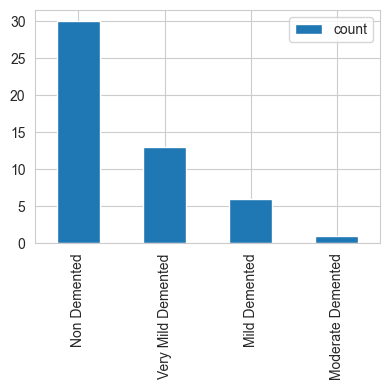

In [123]:
label_plot = label_counts.plot.bar()
plt.show()

****

# **Preprocessing**

### Reshape images

In [125]:
from tensorflow.keras.utils import to_categorical

# Define reshape function
def reshape_X_y(X, y):
    X_array = []
    for x in X:
        X_array.append(x)
    
    y = to_categorical(y)

    # Normalisation
    X_array = np.array(X_array)
    X_array = X_array / 255.0
    
    y = np.array(y)
    
    print(X_array.shape, y.shape)
    return X_array, y

# Training data
X_train_ds, y_train_ds = reshape_X_y(X_train, y_train)

# Validation data
X_val_ds, y_val_ds = reshape_X_y(X_val, y_val)

# Test data
X_test_ds, y_test_ds = reshape_X_y(X_test, y_test)

(37, 128, 128, 3) (37, 4)
(13, 128, 128, 3) (13, 4)
(50, 128, 128, 3) (50, 4)


### Define class names

In [126]:
class_names = np.array(['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'])
print(class_names)

['Non Demented' 'Very Mild Demented' 'Mild Demented' 'Moderate Demented']


****

# **Model building**

### Model 1: *Custom convolutional net*

In [127]:
model1 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Second Block
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [128]:
start = time.time()

history1 = model1.fit(X_train_ds, y_train_ds,
                      steps_per_epoch=len(X_train_ds),
                      batch_size=32,
                      validation_data=(X_val_ds, y_val_ds),
                      validation_steps=len(X_val_ds),
                      epochs=10
)

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.1069 - loss: 1.4036 - val_accuracy: 0.5385 - val_loss: 1.2610
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6209 - loss: 1.1611 - val_accuracy: 0.5385 - val_loss: 1.2100
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6209 - loss: 1.0801 - val_accuracy: 0.5385 - val_loss: 1.1503
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6226 - loss: 1.0375 - val_accuracy: 0.5385 - val_loss: 1.0537
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6217 - loss: 0.9962 - val_accuracy: 0.5385 - val_loss: 0.9362
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6217 - loss: 0.9788 - val_accuracy: 0.5385 - val_loss: 0.9103
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6209 - loss: 1.0332 - val_accuracy: 0.5385 - val_loss: 0.9042
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6200 - loss: 1.0058 - val_accuracy: 0.5385 - val

In [129]:
model1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,642,062 (48.23 MB)

 Trainable params: 4,214,020 (16.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,428,042 (32.15 MB)

In [130]:
history1_plot = pd.DataFrame(history1.history)
history1_plot.head()

,accuracy,loss,val_accuracy,val_loss
0,0.108108,1.403047,0.538462,1.260976
1,0.621622,1.160374,0.538462,1.210008
2,0.621622,1.079146,0.538462,1.150333
3,0.621622,1.038755,0.538462,1.053662
4,0.621622,0.996136,0.538462,0.936240


## **Evaluation**

In [131]:
plt.rcParams['figure.figsize'] = [4, 4]

### Model 1: *Custom Convolutional network*

**Validation loss**

(0.0, 1.0)

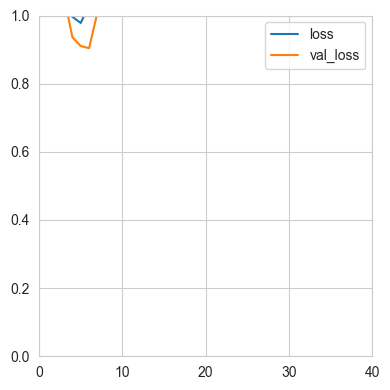

In [132]:
history1_plot.loc[:,['loss', 'val_loss']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

**Validation Accuracy**

(0.0, 1.0)

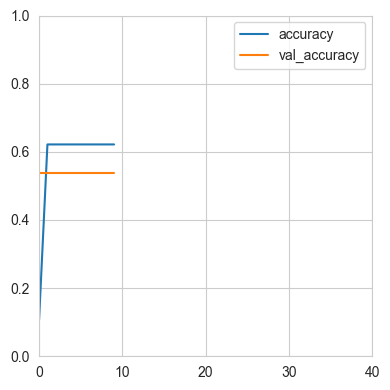

In [133]:
history1_plot.loc[:,['accuracy', 'val_accuracy']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

****

# **Experiment with improving the models**

## Model 1 Experimentation: *Custom convolutional net*

#### Experiment 1: EarlyStopping and Precision

We are going to experiment with using EarlyStopping. Due to the unbalanced classes, it is also a bad idea to use accuracy, thus we will use precision as our metric. As a general rule, changing more than one parameter at a time is not advised, but the use of accuracy as a metric is unlikely to continue, regardless.

In [134]:
# 1. Build experiment 1

model1_1 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    
    # Second Block
    layers.Conv2D(filters=64, activation='relu', padding='same', kernel_size=3),
    layers.MaxPool2D(),
    
    # Output Layers
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

# 2. Compile experiment 1

model1_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['precision'])

# - Define Early Stopping

earlystop1_1 = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10)

# 3. Fit experiment 1

history1_1 = model1_1.fit(X_train_ds, y_train_ds,
                steps_per_epoch=len(X_train_ds),
                validation_data=(X_val_ds, y_val_ds),
                validation_steps=len(X_val_ds),
                batch_size=32,
                epochs=20,
                callbacks=[earlystop1_1])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1.3776 - precision: 0.7784 - val_loss: 1.9995 - val_precision: 0.5385
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2239 - precision: 0.6217 - val_loss: 1.1450 - val_precision: 0.3846
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5223 - precision: 0.2500 - val_loss: 0.9603 - val_precision: 0.6000
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0638 - precision: 0.6545 - val_loss: 1.0740 - val_precision: 0.0000e+00
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0684 - precision: 0.0000e+00 - val_loss: 1.1595 - val_precision: 0.0000e+00
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1057 - precision: 0.0000e+00 - val_loss: 1.1229 - val_precision: 0.7143
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0515 - precision: 0.6802 - val_loss: 1.0887 - val_precision: 0.5385
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9908 - precision: 0.6094

<Axes: >

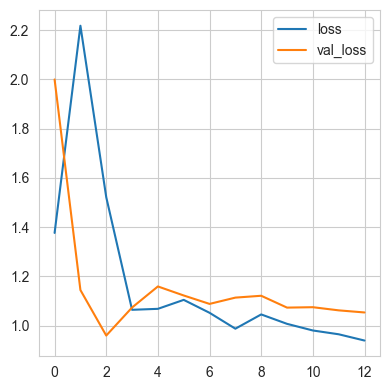

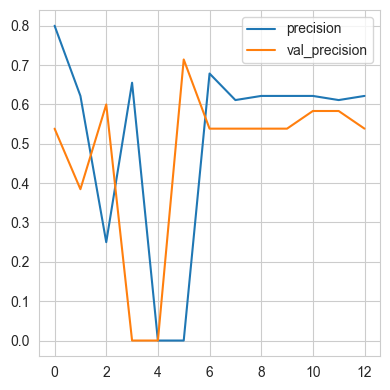

In [135]:
history1_1_plot = pd.DataFrame(history1_1.history)
history1_1_plot.loc[: , ['loss', 'val_loss']].plot()
history1_1_plot.loc[:, ['precision', 'val_precision']].plot()

#### Experiment 2: Finding the ideal learning rate

We can use the callback learning rate scheduler to visualise the most effective learning rate

In [136]:
# 1. Build experiment 2

model1_2 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    
    # Second Block
    layers.Conv2D(filters=64, activation='relu', padding='same', kernel_size=3),
    layers.MaxPool2D(),
    
    # Output Layers
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

# 2. Compile experiment 2

model1_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['precision'])

# - Define Early Stopping
earlystop1_2 = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10)
# - Define Learnrate Scheduler
lrschedule1_2 = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))



# 3. Fit experiment 2

history1_2 = model1_2.fit(X_train_ds, y_train_ds,
                batch_size=32,
                steps_per_epoch=len(X_train_ds),
                validation_data=(X_val_ds, y_val_ds),
                validation_steps=len(X_val_ds),
                epochs=100,
                callbacks=[earlystop1_1, lrschedule1_2])

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1.8424 - precision: 0.5838 - val_loss: 2.3669 - val_precision: 0.5385 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0616 - precision: 0.6209 - val_loss: 1.2038 - val_precision: 0.0000e+00 - learning_rate: 0.0011
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1778 - precision: 0.0000e+00 - val_loss: 1.0868 - val_precision: 0.0000e+00 - learning_rate: 0.0013
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0775 - precision: 0.0000e+00 - val_loss: 0.9838 - val_precision: 0.6000 - learning_rate: 0.0014
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9866 - precision: 0.6913 - val_loss: 0.9533 - val_precision: 0.5385 - learning_rate: 0.0016
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9572 - precision: 0.6094 - val_loss: 1.0176 - val_precision: 0.5385 - learning_rate: 0.0018
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.98

In [137]:
len(history1_2.history['loss'])

18

Text(0.5, 1.0, 'Finding ideal learning rate')

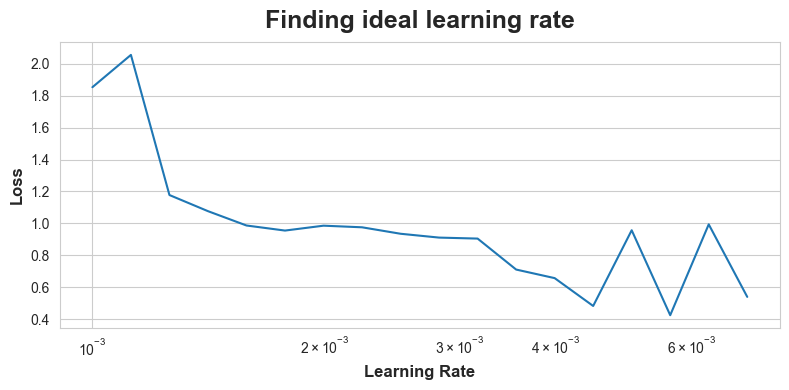

In [138]:
lrs = 1e-3 * (10**(tf.range(len(history1_2.history['loss']))/20))
plt.figure(figsize=(8,4))
plt.semilogx(lrs, history1_2.history['loss'])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Finding ideal learning rate")

It looks like 0.002 - 0.0025 is the ideal learning rate and the ideal number of epochs is 20

#### Experiment 3:

In [139]:
# 1. Build experiment 3

model1_3 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu'),
    layers.MaxPool2D(),
    
    
    # Second Block
    layers.Conv2D(filters=64, activation='relu', kernel_size=3),
    layers.MaxPool2D(),
    
    # Output Layers
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

# 2. Compile experiment 1

lr1_3 = 0.002
epochs1_3 = 20
model1_3.compile(optimizer=tf.keras.optimizers.Adam(epsilon=lr1_3),
                loss='categorical_crossentropy',
                metrics=['precision'])

# - Define Early Stopping
earlystop1_3 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 3. Fit experiment 1

history1_3 = model1_3.fit(X_train_ds, y_train_ds,
                steps_per_epoch=len(X_train_ds),
                batch_size=32,
                validation_data=(X_val_ds, y_val_ds),
                validation_steps=len(X_val_ds),
                epochs=epochs1_3,
                callbacks=[earlystop1_3])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 1.3828 - precision: 0.0000e+00 - val_loss: 1.1457 - val_precision: 0.0000e+00
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0763 - precision: 0.5838 - val_loss: 1.1028 - val_precision: 0.5385
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0196 - precision: 0.6217 - val_loss: 1.0595 - val_precision: 0.5385
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0196 - precision: 0.6217 - val_loss: 0.9494 - val_precision: 0.5385
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9971 - precision: 0.6209 - val_loss: 0.9322 - val_precision: 0.5833
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.9885 - precision: 0.6098 - val_loss: 0.9414 - val_precision: 0.5385
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9744 - precision: 0.6226 - val_loss: 0.9828 - val_precision: 0.5385
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9659 - precision: 0.6217 - val

<Axes: >

<Figure size 800x1200 with 0 Axes>

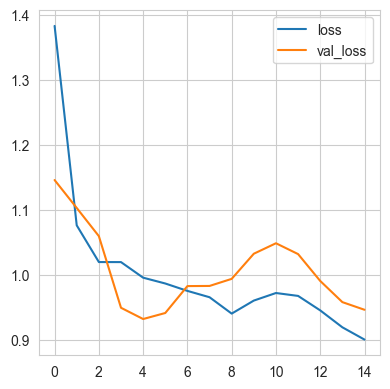

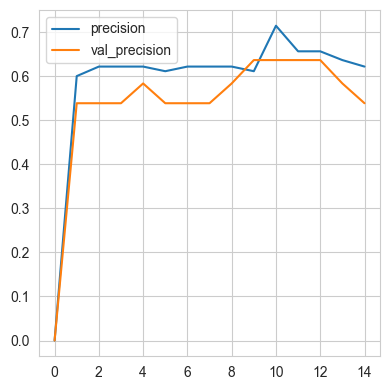

In [140]:
# Plot model
history1_3_plot = pd.DataFrame(history1_3.history)

plt.figure(figsize=(8,12))
history1_3_plot.loc[: , ['loss', 'val_loss']].plot()
history1_3_plot.loc[: , ['precision', 'val_precision']].plot()

#history1_plot.loc[: , ['loss', 'val_loss']].plot()

In [144]:
# Save the model
model1.save('cnn_model.h5')  # Save the model to a file
print('Model saved as cnn_model.h5')

print('It takes %s minutes' % ((time.time() - start)/60))

Model saved as cnn_model.h5
It takes 17.340391699473063 minutes
